In [1]:
!pip install ppscore

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 24.0 MB/s eta 0:00:0000:0100:01
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13161 sha256=bfb518ce3ca6b2ccb308430ee439bfa42ddee0eef5dc6c671ee9436b6a334e9b
  Stored in directory: /root/.cache/pip/wheels/42/87/10/00056aa2d2624f1b9374db6a0d5245da9a3d87bdc9247c1a56
Successfully built ppscore
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Libraries
import math, re, os
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets
import json
import shutil
import zipfile
import re
import tensorflow as tf
import ppscore as pps

# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from joblib import Parallel, delayed

# Data
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

E0000 00:00:1724852329.122019      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0828 13:38:49.130197299      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0828 13:38:49.130213096      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0828 13:38:49.130216501      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0828 13:38:49.130219007      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0828 13:38:49.130221568      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

Tensorflow version 2.16.1


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1724852343.729643      13 service.cc:145] XLA service 0x58e7c1fbabd0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724852343.729697      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1724852343.729701      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1724852343.729704      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1724852343.729707      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1724852343.729710      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1724852343.729713      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1724852343.729715      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1724852343.729718      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [4]:
!pip install --upgrade kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 4.7 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=5f5df0dc283538dd16ddf6894dd57209a529c84871a610876b86065c0e30500d
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [5]:
# Kaggle API Using Secrets

from kaggle_secrets import UserSecretsClient

# Brought key info
user_secrets = UserSecretsClient()
kaggle_key = user_secrets.get_secret("jiyoungroh")

# Setting
os.environ['KAGGLE_KEY'] = kaggle_key
os.environ['KAGGLE_USERNAME'] = "jiyoungroh"

In [6]:
!kaggle competitions download -c playground-series-s4e8

 83%|████████████████████████████████▏      | 68.0M/82.3M [00:00<00:00, 243MB/s]
100%|███████████████████████████████████████| 82.3M/82.3M [00:00<00:00, 240MB/s]


In [7]:
# Unzip
with zipfile.ZipFile('/kaggle/working/playground-series-s4e8.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

# Loading Data
train_data = pd.read_csv('/kaggle/working/train.csv')
test_data = pd.read_csv('/kaggle/working/test.csv')
sample_submission = pd.read_csv('/kaggle/working/sample_submission.csv')

In [8]:
pd.set_option('display.max_columns', None)
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


# 1. PPS Method

In [9]:
pp_scores = []

for col in train_data.columns[1:]:
    pp_score = pps.score(train_data, col, "class")["ppscore"]
    pp_scores.append(pp_score)

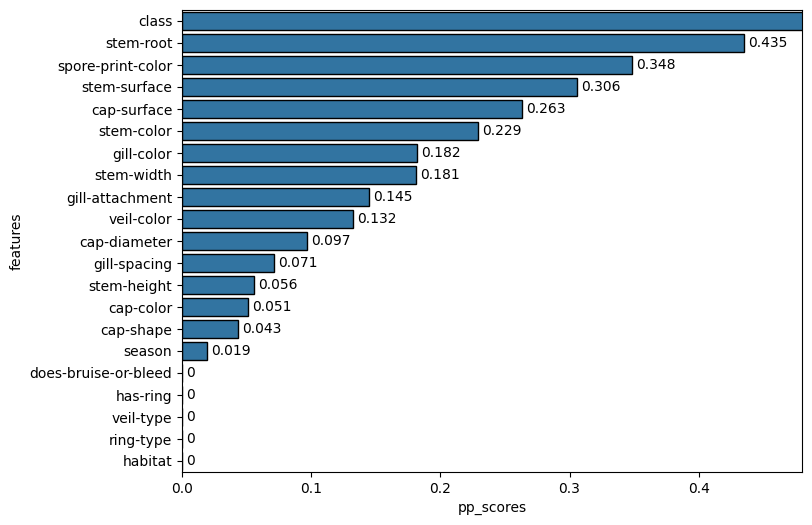

In [10]:
data = pd.DataFrame({
    "features": list(train_data.columns[1:]),
    "pp_scores": np.round(pp_scores, 3)
}).sort_values("pp_scores", ascending = False)

plt.figure(figsize = (8, 6))
ax = sns.barplot(data, x = "pp_scores", y = "features", edgecolor = "#000000")

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=10)
    
plt.xlim(0, 0.48)
plt.show()

In [11]:
def print_poisonous_percentage(col, unique_val):
    n_rows = train_data[train_data[col] == unique_val].shape[0]
    print(f"Rows with value of {unique_val}:", n_rows)
    print("Edible %:", round(train_data[train_data[col] == unique_val]["class"].value_counts(True).iloc[0], 3))
    print("Posionous %:", round(train_data[train_data[col] == unique_val]["class"].value_counts(True).iloc[1], 3))
    print()
    return n_rows

def print_vals(col, vals):
    n_rows = 0
    for val in vals:
        n_rows += print_poisonous_percentage(col = col, unique_val = val)
    print("Total rows", n_rows)

In [12]:
print_vals(col = "stem-root", vals = ["r", "c", "f"])

Rows with value of r: 47803
Edible %: 0.995
Posionous %: 0.005

Rows with value of c: 28592
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 597
Edible %: 0.988
Posionous %: 0.012

Total rows 76992


In [13]:
print_vals(col = "spore-print-color", vals = ["n", "r", "u", "g"])


Rows with value of n: 22646
Edible %: 0.997
Posionous %: 0.003

Rows with value of r: 7975
Edible %: 0.997
Posionous %: 0.003

Rows with value of u: 7256
Edible %: 0.997
Posionous %: 0.003

Rows with value of g: 3492
Edible %: 0.972
Posionous %: 0.028

Total rows 41369


In [14]:
print_vals(col = "stem-surface", vals = ["g", "h", "f"])

Rows with value of g: 78080
Edible %: 0.996
Posionous %: 0.004

Rows with value of h: 28283
Edible %: 0.996
Posionous %: 0.004

Rows with value of f: 512
Edible %: 0.99
Posionous %: 0.01

Total rows 106875


In [15]:
print_vals(col = "stem-color", vals = ["b", "f"])

Rows with value of b: 7365
Edible %: 0.994
Posionous %: 0.006

Rows with value of f: 573
Edible %: 0.981
Posionous %: 0.019

Total rows 7938


In [16]:
# Train Log Numeric
train_data['log_cap-diameter'] = np.log1p(train_data['cap-diameter'])
train_data['log_stem-height'] = np.log1p(train_data['stem-height'])
train_data['log_stem-width'] = np.log1p(train_data['stem-width'])

In [17]:
# Test Log Numeric
test_data['log_cap-diameter'] = np.log1p(test_data['cap-diameter'])
test_data['log_stem-height'] = np.log1p(test_data['stem-height'])
test_data['log_stem-width'] = np.log1p(test_data['stem-width'])

In [18]:
# List of numeric columns to impute
numeric_columns = ['cap-diameter', 'stem-height', 'stem-width', 'log_cap-diameter', 'log_stem-height', 'log_stem-width']

# Replace missing values with the mean of each column
for col in numeric_columns:
    train_data[col].fillna(train_data[col].mean(), inplace=True)

# Check the result
print(train_data[numeric_columns].isnull().sum())

cap-diameter        0
stem-height         0
stem-width          0
log_cap-diameter    0
log_stem-height     0
log_stem-width      0
dtype: int64


In [19]:
# Replace missing values with the mean of each column
for col in numeric_columns:
    test_data[col].fillna(test_data[col].mean(), inplace=True)

# Check the result
print(test_data[numeric_columns].isnull().sum())

cap-diameter        0
stem-height         0
stem-width          0
log_cap-diameter    0
log_stem-height     0
log_stem-width      0
dtype: int64


In [20]:
# Train Label Encoder
for col in ['stem-root', 'spore-print-color', 'stem-surface', 'stem-color', 'gill-color', 'gill-attachment', 
            'veil-color', 'cap-color', 'cap-shape', 'season', 'gill-spacing', 'cap-surface']:
    le = LabelEncoder()
    combined_data = pd.concat([train_data[col]], axis=0).astype(str)
    le.fit(combined_data)
    train_data[col] = le.transform(train_data[col].astype(str))

In [21]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,log_cap-diameter,log_stem-height,log_stem-width
0,0,e,8.80,53,73,73,f,44,28,60,4.51,15.39,27,48,56,NaN,15,f,f,21,d,0,2.282382,1.706565,2.796671
1,1,p,4.51,72,56,65,f,44,28,46,4.79,6.48,27,59,48,NaN,15,t,z,21,d,3,1.706565,1.756132,2.012233
2,2,e,6.94,53,73,49,f,76,28,60,6.85,9.93,27,52,46,NaN,15,f,f,21,l,3,2.071913,2.060514,2.391511
3,3,e,3.88,53,82,57,f,71,41,37,4.16,6.53,27,48,56,NaN,15,f,f,21,d,2,1.585145,1.640937,2.018895
4,4,e,5.85,72,65,75,f,47,41,60,3.37,8.36,27,48,56,NaN,15,f,f,21,g,0,1.924249,1.474763,2.236445


In [22]:
# Train Label Encoder
for col in ['stem-root', 'spore-print-color', 'stem-surface', 'stem-color', 'gill-color', 'gill-attachment', 
            'veil-color', 'cap-color', 'cap-shape', 'season', 'gill-spacing', 'cap-surface']:
    le = LabelEncoder()
    combined_data = pd.concat([test_data[col]], axis=0).astype(str)
    le.fit(combined_data)
    test_data[col] = le.transform(test_data[col].astype(str))

In [23]:
test_data.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,log_cap-diameter,log_stem-height,log_stem-width
0,3116945,8.64,60,47,44,t,54,28,53,11.13,17.12,9,42,52,u,22,t,g,21,d,0,2.265921,2.495682,2.897016
1,3116946,6.90,51,54,46,f,54,17,55,1.27,10.75,21,42,38,NaN,15,f,f,21,d,0,2.066863,0.819780,2.463853
2,3116947,2.00,36,38,44,f,54,17,41,6.18,3.14,21,42,38,NaN,15,f,f,21,d,1,1.098612,1.971299,1.420696
3,3116948,3.47,60,54,44,f,58,17,41,4.98,8.51,21,42,52,NaN,14,t,z,21,d,2,1.497388,1.788421,2.252344
4,3116949,6.17,60,39,56,f,56,28,55,6.73,13.70,21,42,54,NaN,23,t,NaN,21,d,2,1.969906,2.045109,2.687847


In [24]:
#Train

# KNN Imputer reset(k=5 is basic)
imputer = KNNImputer(n_neighbors=5)

# KNN Imputation run (cap-surface, gill-attachment, gill-spacing, stem-surface, ring-type)
train_data[['stem-root', 'spore-print-color', 'stem-surface', 'stem-color', 'gill-color', 'gill-attachment', 
            'veil-color', 'cap-color', 'cap-shape', 'season', 'gill-spacing']] = imputer.fit_transform(
    train_data[['stem-root', 'spore-print-color', 'stem-surface', 'stem-color', 'gill-color', 'gill-attachment', 
            'veil-color', 'cap-color', 'cap-shape', 'season', 'gill-spacing']]
)

In [25]:
#Train

# KNN Imputer reset(k=5 is basic)
imputer = KNNImputer(n_neighbors=5)

# KNN Imputation run (cap-surface, gill-attachment, gill-spacing, stem-surface, ring-type)
test_data[['stem-root', 'spore-print-color', 'stem-surface', 'stem-color', 'gill-color', 'gill-attachment', 
            'veil-color', 'cap-color', 'cap-shape', 'season', 'gill-spacing']] = imputer.fit_transform(
    test_data[['stem-root', 'spore-print-color', 'stem-surface', 'stem-color', 'gill-color', 'gill-attachment', 
            'veil-color', 'cap-color', 'cap-shape', 'season', 'gill-spacing']]
)

In [26]:
# Train

# Data Prepration for PCA
PCA_numeric_data = train_data[['cap-diameter', 'stem-width']].values
PCA_log_numeric_data = train_data[['log_cap-diameter', 'log_stem-width']].values

# PCA Model
pca = PCA(n_components=1)  # Decrease 1 components
pca_result = pca.fit_transform(PCA_numeric_data)

# Add Result of PCA to new column
train_data['pca_cap_stem'] = pca_result

In [27]:
# Test

# Data Prepration for PCA
PCA_numeric_data = test_data[['cap-diameter', 'stem-width']].values
PCA_log_numeric_data = test_data[['log_cap-diameter', 'log_stem-width']].values

# PCA Model
pca = PCA(n_components=1)  # Decrease 1 components
pca_result = pca.fit_transform(PCA_numeric_data)

# Add Result of PCA to new column
test_data['pca_cap_stem'] = pca_result

In [28]:
test_data.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,log_cap-diameter,log_stem-height,log_stem-width,pca_cap_stem
0,3116945,8.64,60.0,47,44.0,t,54.0,28.0,53.0,11.13,17.12,9.0,42.0,52.0,u,22.0,t,g,21.0,d,0.0,2.265921,2.495682,2.897016,6.389057
1,3116946,6.90,51.0,54,46.0,f,54.0,17.0,55.0,1.27,10.75,21.0,42.0,38.0,NaN,15.0,f,f,21.0,d,0.0,2.066863,0.819780,2.463853,-0.096032
2,3116947,2.00,36.0,38,44.0,f,54.0,17.0,41.0,6.18,3.14,21.0,42.0,38.0,NaN,15.0,f,f,21.0,d,1.0,1.098612,1.971299,1.420696,-9.086434
3,3116948,3.47,60.0,54,44.0,f,58.0,17.0,41.0,4.98,8.51,21.0,42.0,52.0,NaN,14.0,t,z,21.0,d,2.0,1.497388,1.788421,2.252344,-3.618022
4,3116949,6.17,60.0,39,56.0,f,56.0,28.0,55.0,6.73,13.70,21.0,42.0,54.0,NaN,23.0,t,NaN,21.0,d,2.0,1.969906,2.045109,2.687847,2.230671


In [29]:
selected_features = ['id','cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 
                     'stem-height', 'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'spore-print-color',
                    'season', 'pca_cap_stem']
log_selected_features = ['id','cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 
                     'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'spore-print-color',
                    'season', 'log_cap-diameter', 'log_stem-height', 'log_stem-width']

In [30]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,log_cap-diameter,log_stem-height,log_stem-width,pca_cap_stem
0,0,e,8.80,53.0,73,73.0,f,44.0,28.0,60.0,4.51,15.39,27.0,48.0,56.0,NaN,15.0,f,f,21.0,d,0.0,2.282382,1.706565,2.796671,4.899375
1,1,p,4.51,72.0,56,65.0,f,44.0,28.0,46.0,4.79,6.48,27.0,59.0,48.0,NaN,15.0,t,z,21.0,d,3.0,1.706565,1.756132,2.012233,-4.989452
2,2,e,6.94,53.0,73,49.0,f,76.0,28.0,60.0,6.85,9.93,27.0,52.0,46.0,NaN,15.0,f,f,21.0,l,3.0,2.071913,2.060514,2.391511,-0.822876
3,3,e,3.88,53.0,82,57.0,f,71.0,41.0,37.0,4.16,6.53,27.0,48.0,56.0,NaN,15.0,f,f,21.0,d,2.0,1.585145,1.640937,2.018895,-5.221121
4,4,e,5.85,72.0,65,75.0,f,47.0,41.0,60.0,3.37,8.36,27.0,48.0,56.0,NaN,15.0,f,f,21.0,g,0.0,1.924249,1.474763,2.236445,-2.712022


In [31]:
test_data.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,log_cap-diameter,log_stem-height,log_stem-width,pca_cap_stem
0,3116945,8.64,60.0,47,44.0,t,54.0,28.0,53.0,11.13,17.12,9.0,42.0,52.0,u,22.0,t,g,21.0,d,0.0,2.265921,2.495682,2.897016,6.389057
1,3116946,6.90,51.0,54,46.0,f,54.0,17.0,55.0,1.27,10.75,21.0,42.0,38.0,NaN,15.0,f,f,21.0,d,0.0,2.066863,0.819780,2.463853,-0.096032
2,3116947,2.00,36.0,38,44.0,f,54.0,17.0,41.0,6.18,3.14,21.0,42.0,38.0,NaN,15.0,f,f,21.0,d,1.0,1.098612,1.971299,1.420696,-9.086434
3,3116948,3.47,60.0,54,44.0,f,58.0,17.0,41.0,4.98,8.51,21.0,42.0,52.0,NaN,14.0,t,z,21.0,d,2.0,1.497388,1.788421,2.252344,-3.618022
4,3116949,6.17,60.0,39,56.0,f,56.0,28.0,55.0,6.73,13.70,21.0,42.0,54.0,NaN,23.0,t,NaN,21.0,d,2.0,1.969906,2.045109,2.687847,2.230671


In [32]:
train_selected_features = log_selected_features + ['class_e', 'class_p']
test_data = test_data[log_selected_features]

In [33]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,log_cap-diameter,log_stem-height,log_stem-width,pca_cap_stem
0,0,e,8.80,53.0,73,73.0,f,44.0,28.0,60.0,4.51,15.39,27.0,48.0,56.0,NaN,15.0,f,f,21.0,d,0.0,2.282382,1.706565,2.796671,4.899375
1,1,p,4.51,72.0,56,65.0,f,44.0,28.0,46.0,4.79,6.48,27.0,59.0,48.0,NaN,15.0,t,z,21.0,d,3.0,1.706565,1.756132,2.012233,-4.989452
2,2,e,6.94,53.0,73,49.0,f,76.0,28.0,60.0,6.85,9.93,27.0,52.0,46.0,NaN,15.0,f,f,21.0,l,3.0,2.071913,2.060514,2.391511,-0.822876
3,3,e,3.88,53.0,82,57.0,f,71.0,41.0,37.0,4.16,6.53,27.0,48.0,56.0,NaN,15.0,f,f,21.0,d,2.0,1.585145,1.640937,2.018895,-5.221121
4,4,e,5.85,72.0,65,75.0,f,47.0,41.0,60.0,3.37,8.36,27.0,48.0,56.0,NaN,15.0,f,f,21.0,g,0.0,1.924249,1.474763,2.236445,-2.712022


In [34]:
test_data.head()

,id,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-color,spore-print-color,season,log_cap-diameter,log_stem-height,log_stem-width
0,3116945,60.0,47,44.0,54.0,28.0,53.0,9.0,42.0,52.0,22.0,21.0,0.0,2.265921,2.495682,2.897016
1,3116946,51.0,54,46.0,54.0,17.0,55.0,21.0,42.0,38.0,15.0,21.0,0.0,2.066863,0.819780,2.463853
2,3116947,36.0,38,44.0,54.0,17.0,41.0,21.0,42.0,38.0,15.0,21.0,1.0,1.098612,1.971299,1.420696
3,3116948,60.0,54,44.0,58.0,17.0,41.0,21.0,42.0,52.0,14.0,21.0,2.0,1.497388,1.788421,2.252344
4,3116949,60.0,39,56.0,56.0,28.0,55.0,21.0,42.0,54.0,23.0,21.0,2.0,1.969906,2.045109,2.687847


In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_data[selected_features], train_data[['class_e', 'class_p']], test_size=0.2, random_state=42)

KeyError: "None of [Index(['class_e', 'class_p'], dtype='object')] are in the [columns]"

## 2. Modeling

In [ ]:
# Logistic Regression

with strategy.scope():
    model_lr = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model_lr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_lr = model_lr.fit(X_train, y_train['class_e'], epochs=10, batch_size=1024, validation_split=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_rf = RandomForestClassifier(warm_start=True, random_state=42)
n_trees = 10  # Total number of trees
step = 1  # Number of trees to add at each iteration
accuracies = []

for i in range(step, n_trees + step, step):
    model_rf.set_params(n_estimators=i)
    model_rf.fit(X_train, y_train['class_e'])
    
    preds_rf = model_rf.predict(X_train)
    acc_rf = accuracy_score(y_train['class_e'], preds_rf)
    accuracies.append(acc_rf)
    print(f"Number of Trees: {i}, Accuracy: {acc_rf:.4f}")

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False) 
model_xgb.fit(X_train, y_train['class_e'])

In [ ]:
preds_rf_test = model_rf.predict(test_data)

In [ ]:
# Ensure preds_rf_test is in the correct format (list or array of integers)
preds_rf_test = preds_rf_test.astype(int)

# Convert predictions: 0 -> 'e', 1 -> 'p'
class_predictions = ['e' if pred == 0 else 'p' for pred in preds_rf_test]

# Create a DataFrame with the IDs and the converted predictions
results_df = pd.DataFrame({
    'id': test_data['id'],
    'class': class_predictions
})

# Display the first 10 rows
print(results_df.head(10))

In [ ]:
len(results_df)

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('/kaggle/working/results_rf_test.csv', index=False)

# Confirm the file has been saved
print("File saved as: /kaggle/working/results_rf_test.csv")

## 3. XGBoost

In [ ]:
preds_XGB_test = model_xgb.predict(test_data)

In [ ]:
# Ensure preds_rf_test is in the correct format (list or array of integers)
preds_XGB_test = preds_XGB_test.astype(int)

# Convert predictions: 0 -> 'e', 1 -> 'p'
class_predictions = ['e' if pred == 0 else 'p' for pred in preds_XGB_test]

# Create a DataFrame with the IDs and the converted predictions
results_df = pd.DataFrame({
    'id': test_data['id'],
    'class': class_predictions
})

# Display the first 10 rows
print(results_df.head(10))

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('/kaggle/working/results_xgb_test.csv', index=False)

# Confirm the file has been saved
print("File saved as: /kaggle/working/results_xgb_test.csv")

# 4. LG

In [ ]:
preds_lr_test = model_lr.predict(test_data)

In [ ]:
# Ensure preds_rf_test is in the correct format (list or array of integers)
preds_Xlr_test = preds_lr_test.astype(int)

# Convert predictions: 0 -> 'e', 1 -> 'p'
class_predictions = ['e' if pred == 0 else 'p' for pred in preds_lr_test]

# Create a DataFrame with the IDs and the converted predictions
results_df = pd.DataFrame({
    'id': test_data['id'],
    'class': class_predictions
})

# Display the first 10 rows
print(results_df.head(10))

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('/kaggle/working/results_lr_test.csv', index=False)

# Confirm the file has been saved
print("File saved as: /kaggle/working/results_lr_test.csv")